In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import time as tm
import Recommenders as rc
import Evaluation as ev
%matplotlib

Using matplotlib backend: agg


# New section

In [ ]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_df_1 = pd.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 =  pd.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pd.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left")

song_df.head()

In [ ]:
len(song_df)

10000

In [ ]:
#Create a subset of the dataset
song_df = song_df.head(10000)

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
...,...,...,...
5139,high fives - Four Tet,1,0.01
5140,in white rooms - Booka Shade,1,0.01
5143,paranoid android - Christopher O'Riley,1,0.01
5149,¿Lo Ves? [Piano Y Voz] - Alejandro Sanz,1,0.01


In [ ]:
#Count number of unique users in the dataset
users = song_df['user_id'].unique()
len(users)

365

In [ ]:
#Fill in the code here
songs = song_df['song'].unique()
len(songs)

5151

In [ ]:
#We arbitrarily pick 20% as our testing size.
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)

#Create an instance of popularity based recommender
pm = rc.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

#Use the popularity model to make some predictions
user_id = users[7]
pm.recommend(user_id)

In [ ]:
#Fill in the code here
user_id = users[30]
pm.recommend(user_id)

In [ ]:
#Recommenders.item_similarity_recommender_py

#Create an instance of item similarity based recommender 
is_model = rc.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

#Use the personalized model to make some song recommendations
#Print the songs for the user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

In [ ]:
#Use the personalized model to make recommendations for the following user id. (Note the difference in recommendations from the first user id.)
user_id = users[25]

#Fill in the code here
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

In [ ]:
#We can also apply the model to find similar songs to any song in the dataset
is_model.get_similar_items(['Too Deep - Girl Talk'])

In [ ]:
#Use the personalized recommender model to get similar songs for the following song.
song = 'Too Deep - Girl Talk'

#Fill in the code here
is_model.get_similar_items([song])

In [ ]:
#Class to calculate precision and recall (This can be used as a black box)

#Evaluation.precision_recall_calculator
#Use the above precision recall calculator class to calculate the evaluation measures

start = tm.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = ev.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = tm.time()
print(end - start)

In [ ]:
#Code to plot precision recall curve
import pylab as pl
!pip install joblib
from sklearn.externals import joblib

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    plt.clf()    
    plt.plot(m1_recall_list, m1_precision_list, label=m1_label)
    plt.plot(m2_recall_list, m2_precision_list, label=m2_label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 0.20])
    plt.xlim([0.0, 0.20])
    plt.title('Precision-Recall curve')
    #plt.legend(loc="upper right")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    plt.show()

print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

In [ ]:
#Generate Precision Recall curve using pickled results on a larger data subset(Python 3)
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

#Read the persisted files 
pm_avg_precision_list = joblib.load('content/pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('content/pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('content/ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('content/ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

In [ ]:
#Matrix Factorization based Recommender System
!pip install sparsesvd
import math as mt
import csv
from sparsesvd import sparsesvd #used for matrix factorization
import numpy as np
from scipy.sparse import csc_matrix #used for sparse matrix
from scipy.sparse.linalg import * #used for matrix multiplication

In [ ]:
#constants defining the dimensions of our User Rating Matrix (URM)
MAX_PID = 4
MAX_UID = 5

#Compute SVD of the user ratings matrix
def computeSVD(urm, K):
    U, s, Vt = sparsesvd(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(np.transpose(U), dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

#Compute estimated rating for the test user
def computeEstimatedRatings(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 

    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        #we convert the vector to dense format in order to get the indices 
        #of the movies with the best estimated ratings 
        estimatedRatings[userTest, :] = prod.todense()
        recom = (-estimatedRatings[userTest, :]).argsort()[:250]
    return recom

In [ ]:
#Used in SVD calculation (number of latent factors)
K=2

#Initialize a sample user rating matrix
urm = np.array([[3, 0, 2, 3],[4, 3, 4, 3],[0, 2, 1, 5], [1, 4, 5, 2], [5, 0,0 , 0]])
urm = csc_matrix(urm, dtype=np.float32)

#Compute SVD of the input user ratings matrix
U, S, Vt = computeSVD(urm, K)

#Test user set as user_id 4 with ratings [0, 0, 5, 0]
uTest = [4]
print("User id for whom recommendations are needed: %d" % uTest[0])

#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = computeEstimatedRatings(urm, U, S, Vt, uTest, K, True)
print(uTest_recommended_items)

User id for whom recommendations are needed: 4
Predictied ratings:
[0 2 3 1]


Matrix Dimensions for U
(5, 2)


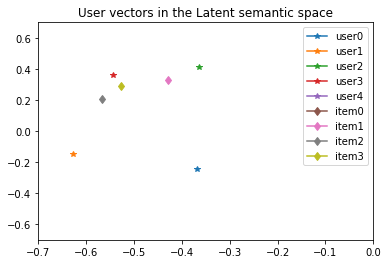

In [ ]:
#Understanding Intuition behind SVD
%matplotlib inline
from pylab import *

#Plot all the users
print("Matrix Dimensions for U")
print(U.shape)

for i in range(0, U.shape[0]):
    plot(U[i,0], U[i,1], marker = "*", label="user"+str(i))

for j in range(0, Vt.T.shape[0]):
    plot(Vt.T[j,0], Vt.T[j,1], marker = 'd', label="item"+str(j))    
    
legend(loc="upper right")
title('User vectors in the Latent semantic space')
ylim([-0.7, 0.7])
xlim([-0.7, 0])
show()